# Marmoset Dataset Example

The Marmoset dataset is related to Lauer et al. 2022 (Nature Methods) under CC BY-NC 4.0. In this example, there are two marmosets in the images extracted from the recorded video. One had its ears dyed blue. The other one's ears remained white.

Train dataset: [https://zenodo.org/records/5849371](https://zenodo.org/records/5849371)

Test dataset: [https://zenodo.org/records/8437121](https://zenodo.org/records/8437121)

## Preparation
1. Download and extract the training dataset.

In [1]:
%%bash

# Define variables
TARGET_DIR="dataset/marmoset-train/"
ZIP_FILE="marmoset-train-dataset.zip"
URL="https://zenodo.org/records/5849371/files/marmoset-dlc-2021-05-07.zip?download=1"

# Check if the directory exists
if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    # Download the file
    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    # Create parent directories
    mkdir -p "$TARGET_DIR"

    # Unzip the file
    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    # Remove the zip file
    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded train dataset."

dataset/marmoset-train/ does not exist. Proceeding to download and extract...
Downloaded marmoset-train-dataset.zip.
Extracted files to dataset/marmoset-train/.
Removed marmoset-train-dataset.zip.
Successfully downloaded train dataset.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1834M  100 1834M    0     0  12.0M      0  0:02:31  0:02:31 --:--:-- 13.0M


2. Similarly, download and extract test dataset.

In [2]:
%%bash

TARGET_DIR="dataset/marmoset-test/"
ZIP_FILE="marmoset-test-dataset.zip"
URL="https://zenodo.org/records/8437121/files/marmoset-dlc-2021-05-07.zip?download=1"

if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    mkdir -p "$TARGET_DIR"

    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded test dataset."

dataset/marmoset-test/ does not exist. Proceeding to download and extract...
Downloaded marmoset-test-dataset.zip.
Extracted files to dataset/marmoset-test/.
Removed marmoset-test-dataset.zip.
Successfully downloaded test dataset.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  776M  100  776M    0     0  12.4M      0  0:01:02  0:01:02 --:--:-- 13.1M


3. Download dependecies

In [3]:
%pip install --upgrade ultralytics deeplabcut2yolo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 23.2 MB/s eta 0:00:00


## Convert DeepLabCut (DLC) to YOLO

1. Setup the arguments for d2y.

In [4]:
import deeplabcut2yolo as d2y
from pathlib import Path

dataset_path = Path("dataset/marmoset-train/marmoset-dlc-2021-05-07")  # Dataset directory to convert using d2y
# Note that the test dataset has no label and does not need to be converted

# List of directories (the folder of images) for training and validation.
train_path = dataset_path / "labeled-data/reachingvideo1"
val_path = dataset_path / "labeled-data/refinement1"

"""
This is the defined skeleton of the marmoset in the config.yaml
- Front 0
- Right 1
- Middle 2
- Left 3
- FL1 4
- BL1 5
- FR1 6
- BR1 7
- BL2 8
- BR2 9
- FL2 10
- FR2 11
- Body1 12
- Body2 13
- Body3 14
"""

skeleton_symmetric_pairs=[(1, 3), (4, 6), (5, 7), (8, 9), (10, 11)]

# Let's add the class names
class_names=["Blue", "White"]

2. Run the conversion.

In [5]:
d2y.convert(
    dataset_path=dataset_path,
    train_paths=train_path,
    val_paths=val_path,
    skeleton_symmetric_pairs=skeleton_symmetric_pairs,
    data_yml_path="data.yml",
    class_names=class_names,
    verbose=True,
)

DeepLabCut2YOLO

Dataset path: dataset/marmoset-train/marmoset-dlc-2021-05-07
Found pickled labels: dataset/marmoset-train/marmoset-dlc-2021-05-07/training-datasets/iteration-0/UnaugmentedDataSet_marmosetMay7/marmoset_dlc70shuffle1.pickle
Found config file: dataset/marmoset-train/marmoset-dlc-2021-05-07/config.yaml
  nc: 2
  names: {0: 'B', 1: 'W'}
  kpt: ['Front', 'Right', 'Middle', 'Left', 'FL1', 'BL1', 'FR1', 'BR1', 'BL2', 'BR2', 'FL2', 'FR2', 'Body1', 'Body2', 'Body3']
  kpt_shape: [15, 3]
Generating data.yml...
Created data.yml: data.yml
  path: /content
  train: ['dataset/marmoset-train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1']
  val: ['dataset/marmoset-train/marmoset-dlc-2021-05-07/labeled-data/refinement1']
  kpt_shape: [15, 3]
  flip_idx: [0, 3, 2, 1, 6, 7, 4, 5, 9, 8, 11, 10, 12, 13, 14]
  nc: 2
  names: {0: 'Blue', 1: 'White'}
Converting labels...


100%|██████████| 5316/5316 [00:01<00:00, 3567.90it/s]


Conversion completed!


## YOLO Transfer Learning

The marmoset dataset is relatively large. The training can take a long time.

In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n-pose.pt").load('yolov8n-pose.pt')
model.train(data="data.yml", epochs=20, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.52M/6.52M [00:00<00:00, 88.1MB/s]


Transferred 397/397 items from pretrained weights
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=data.yml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8n-pose.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[15, 3]
Overriding model.yaml nc=1 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True

100%|██████████| 5.35M/5.35M [00:00<00:00, 78.0MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/marmoset-train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1... 4892 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4892/4892 [00:05<00:00, 874.93it/s]


train: New cache created: /content/dataset/marmoset-train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/marmoset-train/marmoset-dlc-2021-05-07/labeled-data/refinement1... 424 images, 0 backgrounds, 0 corrupt: 100%|██████████| 424/424 [00:01<00:00, 354.29it/s]

val: New cache created: /content/dataset/marmoset-train/marmoset-dlc-2021-05-07/labeled-data/refinement1.cache


Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.65G      1.569      9.978     0.6286      2.127      1.498         34        640: 100%|██████████| 306/306 [02:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


                   all        424        783      0.313      0.561      0.298      0.114    0.00444    0.00766   0.000175   1.75e-05

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.29G      1.493      7.987      0.557      1.625      1.399         29        640: 100%|██████████| 306/306 [01:54<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


                   all        424        783      0.314      0.557      0.316      0.134     0.0199     0.0408    0.00209   0.000376

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.28G      1.491       7.41     0.5482      1.539      1.385         26        640: 100%|██████████| 306/306 [01:57<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.26it/s]

                   all        424        783      0.373      0.595      0.353      0.146     0.0579     0.0727     0.0151    0.00268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.27G      1.462       6.96     0.5287      1.488      1.368         26        640: 100%|██████████| 306/306 [01:54<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]

                   all        424        783      0.379      0.631      0.377      0.171     0.0933      0.132     0.0272    0.00501



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.28G      1.416      6.575     0.5063      1.421      1.339         21        640: 100%|██████████| 306/306 [01:59<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]

                   all        424        783        0.4      0.577      0.372      0.161      0.116      0.136     0.0347    0.00716



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.27G      1.364      6.181     0.4823      1.357        1.3         25        640: 100%|██████████| 306/306 [01:55<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.49it/s]

                   all        424        783      0.398       0.62      0.407        0.2      0.129      0.176     0.0515      0.011



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.27G      1.335      5.947     0.4649      1.305      1.288         30        640: 100%|██████████| 306/306 [01:54<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


                   all        424        783      0.409      0.656      0.417      0.209      0.157       0.21     0.0727     0.0147

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.27G      1.297      5.758     0.4541      1.236      1.257         23        640: 100%|██████████| 306/306 [01:54<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]

                   all        424        783      0.397      0.616      0.437      0.208      0.194      0.195     0.0728     0.0162



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.27G      1.268      5.515     0.4402      1.105      1.227         28        640: 100%|██████████| 306/306 [01:53<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]

                   all        424        783      0.477      0.587      0.538      0.269      0.259      0.224      0.113     0.0274



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.27G      1.255      5.392      0.434      1.062      1.218         26        640: 100%|██████████| 306/306 [01:57<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


                   all        424        783       0.47      0.621      0.531      0.279      0.241      0.265      0.143     0.0345
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.27G      1.103      3.975     0.3294     0.8101      1.159         14        640: 100%|██████████| 306/306 [01:52<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.98it/s]

                   all        424        783      0.542      0.611      0.587      0.307      0.342       0.28      0.176      0.043



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.27G      1.076      3.753     0.3178     0.7614      1.146         13        640: 100%|██████████| 306/306 [01:51<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


                   all        424        783      0.625      0.566      0.621      0.326      0.378      0.292      0.212     0.0594

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.27G      1.032       3.56     0.3135     0.7093       1.11         14        640: 100%|██████████| 306/306 [01:48<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]

                   all        424        783      0.599       0.62      0.636       0.34      0.364        0.3        0.2     0.0554



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.27G      1.008      3.453     0.3088     0.6727      1.103         13        640: 100%|██████████| 306/306 [01:51<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.47it/s]

                   all        424        783      0.667      0.616      0.695      0.389      0.424      0.319       0.26       0.07



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.27G      0.974      3.326     0.3058     0.6418      1.078         13        640: 100%|██████████| 306/306 [01:49<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


                   all        424        783      0.671       0.65      0.706      0.397      0.469       0.34      0.285     0.0831

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.27G     0.9497      3.177     0.3027      0.612      1.069         16        640: 100%|██████████| 306/306 [01:49<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]

                   all        424        783      0.744      0.621       0.71      0.401      0.486      0.351      0.289     0.0858



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.27G     0.9171      3.065     0.3026     0.5848      1.048         13        640: 100%|██████████| 306/306 [01:49<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.51it/s]

                   all        424        783       0.67      0.634      0.689      0.398      0.551      0.339      0.296     0.0878



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.27G      0.888      2.972     0.2978     0.5637      1.037         13        640: 100%|██████████| 306/306 [01:49<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]

                   all        424        783       0.76      0.647       0.74      0.432      0.531      0.404       0.34      0.103



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.27G     0.8657      2.893     0.2985     0.5455      1.026         15        640: 100%|██████████| 306/306 [01:50<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.00it/s]

                   all        424        783       0.77       0.65      0.737      0.429      0.516      0.425      0.357      0.106



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.27G     0.8442      2.812     0.2999      0.522      1.019         13        640: 100%|██████████| 306/306 [01:50<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]

                   all        424        783       0.75      0.672      0.743      0.438      0.583      0.415      0.369      0.117



20 epochs completed in 0.689 hours.
Optimizer stripped from runs/pose/train/weights/last.pt, 6.7MB
Optimizer stripped from runs/pose/train/weights/best.pt, 6.7MB

Validating runs/pose/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-pose summary (fused): 187 layers, 3,248,633 parameters, 0 gradients, 9.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


                   all        424        783      0.752      0.672      0.743      0.438      0.583      0.415      0.369      0.117
                  Blue        389        389      0.744      0.684      0.737       0.42      0.574      0.432      0.363      0.114
                 White        394        394       0.76       0.66      0.749      0.456      0.593      0.398      0.375       0.12
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/pose/train


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7909437f4820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

First, verify that d2y correctly converted the labels and keypoints. Does the points on the marmosets look correct to you?

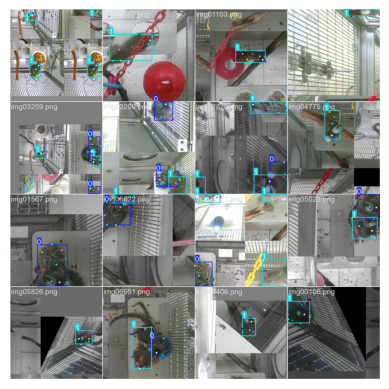

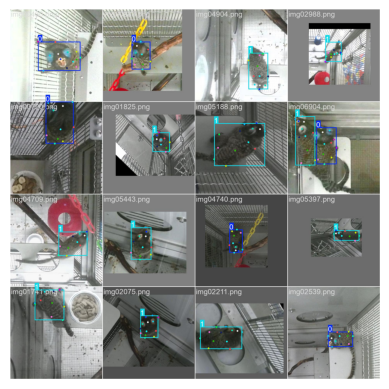

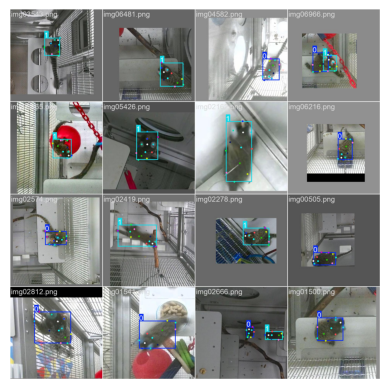

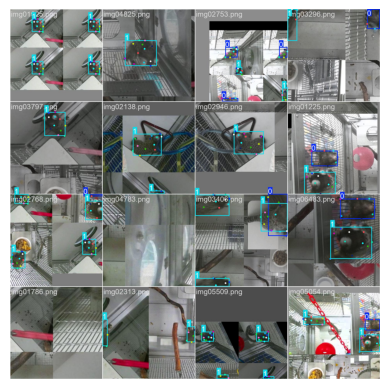

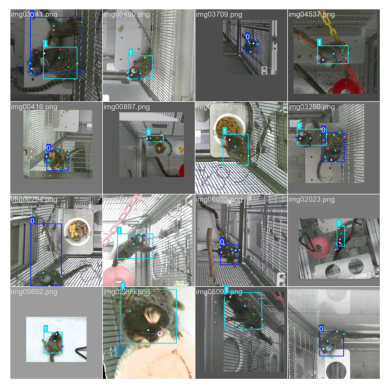

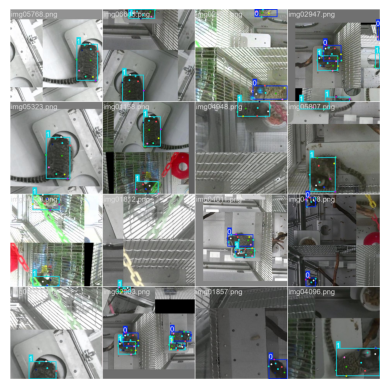

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

for path in Path("/content/runs/pose/train/").glob("train_batch*.jpg"):
  image = Image.open(path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

Here are the validation results from the transfer learning.

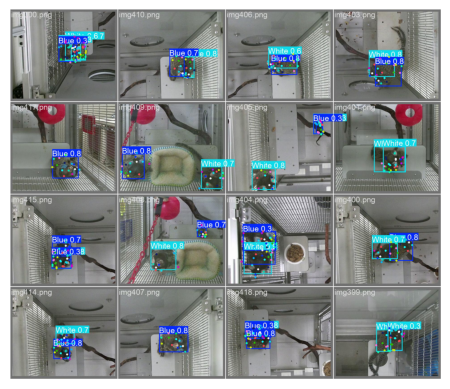

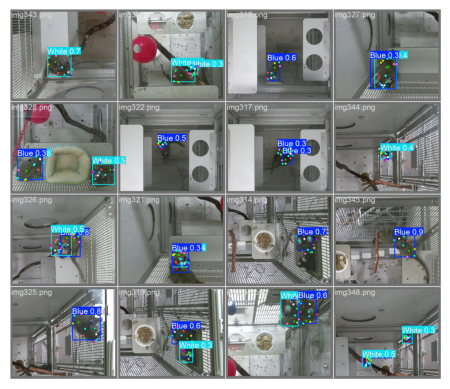

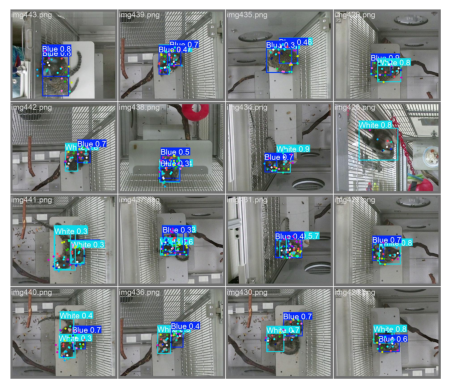

In [8]:
for path in Path("/content/runs/pose/train/").glob("val_batch*_pred.jpg"):
  image = Image.open(path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

## Test the Model

1. Predict test images and save them.

In [9]:
from tqdm import tqdm

predict_dir = Path("prediction-results")
predict_dir.mkdir(parents=True, exist_ok=True) # Make the directories if it does not exist

image_paths=list(Path("/content/dataset/marmoset-test/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1").glob("*"))
for path in tqdm(image_paths):
  results = model(path, verbose=False)
  save_path = predict_dir / path.name
  results[0].save(save_path)

100%|██████████| 2108/2108 [01:26<00:00, 24.39it/s]


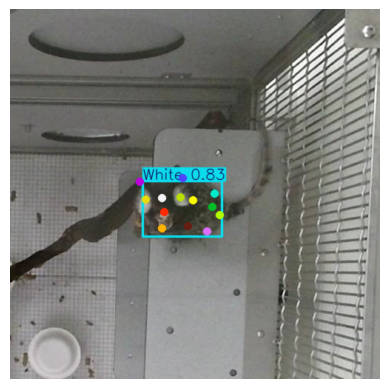

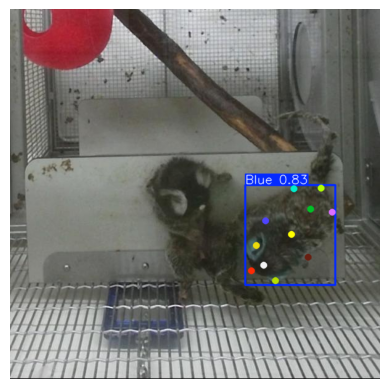

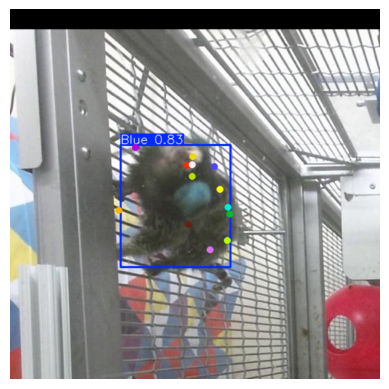

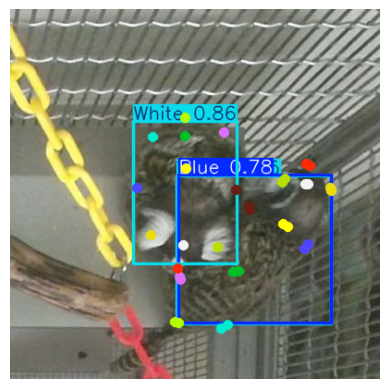

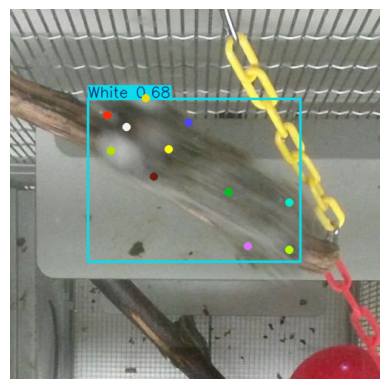

In [10]:
for path in list(Path("/content/prediction-results").glob("*.png"))[20:25]:
  image = Image.open(path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

3. Let's make a video from the prediction.

In [11]:
# This is some hacky fix for Colab encoding issue

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [12]:
!cat $(find prediction-results -maxdepth 1 -name "*.png" | sort -V) | ffmpeg -framerate 5 -i - marmoset-prediction.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab